# Quantitative omics 
The exercises of this notebook correspond to different steps of the data analysis of quantitative omics data. We use data from transcriptomics and proteomics experiments.


## Installation of libraries and necessary software

Copy the files *me_bestprobes.csv* and _AllQuantProteinsInAllSamples.csv_ into the folder that contains this jupyter notebook or upload them to http://localhost:8888/tree


Install the necessary libraries (only needed once) by executing (shift-enter) the following cell:


In [ ]:
install.packages("DAAG", repos='http://cran.us.r-project.org')
install.packages("MASS", repos='http://cran.us.r-project.org')
install.packages("matrixStats", repos='http://cran.us.r-project.org')
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("Biobase","preprocessCore","qvalue","limma"))

## Loading data and libraries
This requires that the installation above have been finished without error

In [2]:
library("MASS")
library("DAAG")
library("matrixStats")
library("Biobase")
library("preprocessCore")
library("qvalue")
library("limma")

me_Kalinka <- read.csv("me_bestprobes.csv",row.names=1)
CanceriTRAQ <- read.csv("AllQuantProteinsInAllSamples.csv",row.names=1)

Loading required package: lattice


Attaching package: ‘DAAG’


The following object is masked from ‘package:MASS’:

    hills


Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, wh

### Exercise 1

We apply different ways of normalization to a typical microarray data set. 

Get the data ```geneData``` from the ```Biobase``` package. Normalize the columns (by division on normal scale or subtraction on log-scale) by a) mean, b) median, c) mean of log-values, and d) median of log-values. Revise the results extensively by comparing the multiple distributions in histograms, density plots, ranked plots and ```qqnorm```. Do also a direct comparison between replicates by scatter plots.




In [ ]:
data(geneData)
geneData[geneData<=0] <- NA
logDat <- log2(geneData)



##### Question I:  <u>Would you plot the data on log-scale or on normal scale?</u>

_Answer_

##### Question II:  <u>What does qqnorm tell us?</u>

_Answer_

##### Question III:  <u>What is the problem when normalizing by the mean on normal scale?</u>

_Answer_

##### Question IV:  <u>What is the difference between normalization b) and d)?</u>

_Answer_



### Exercise 2

Here, we will determine differentially regulated genes from the comparison between different sample groups of geneData. 

a) Take the log-transformed ```geneData``` set and perform t-tests for all genes between sample groups (B, I, K, N, P, T) and (C, G, J, O, R, U, V). You can copy and modifiy the code from the lecture. Do not forget to correct for multiple testing. Plot a histogram of the p-values and generate a volcano plot.

b) In order to see whether the t-tests also provide results for any comparison, take randomly chosen samples of 6 versus 6 groups and redo the statistical tests.

c) Carry out a principal component analysis on the entire data set and look for the groups that you tested for significantly different genes (loading plot) in a).


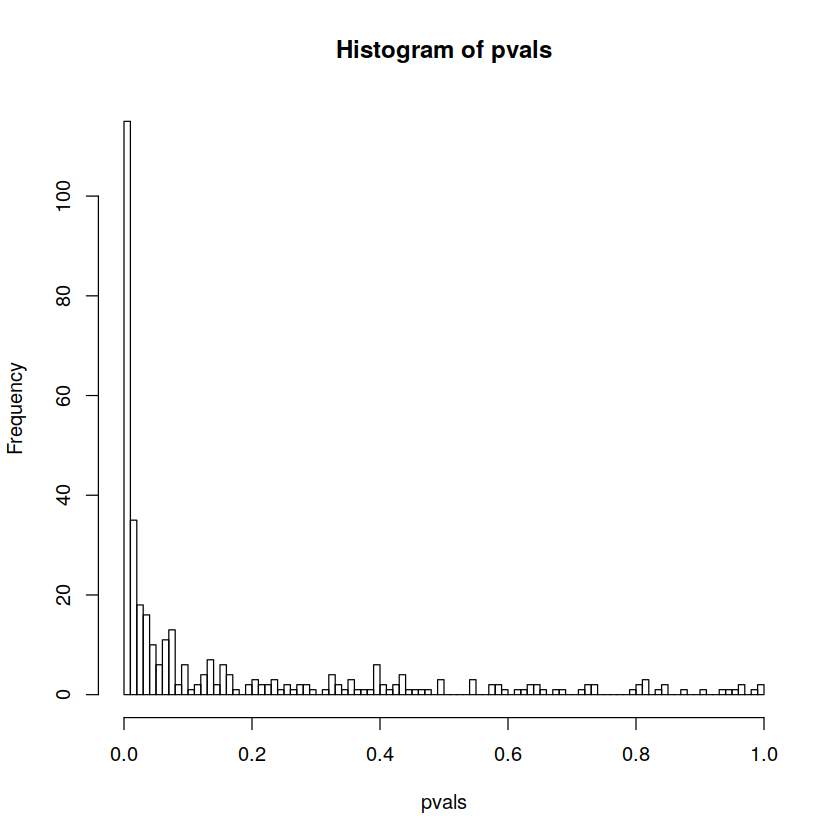

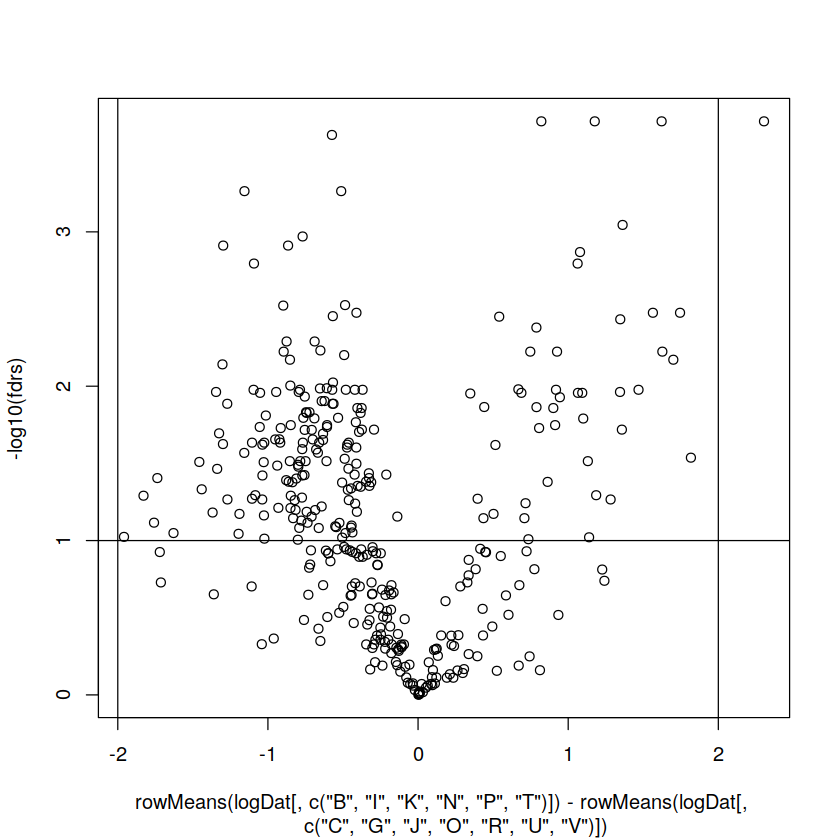

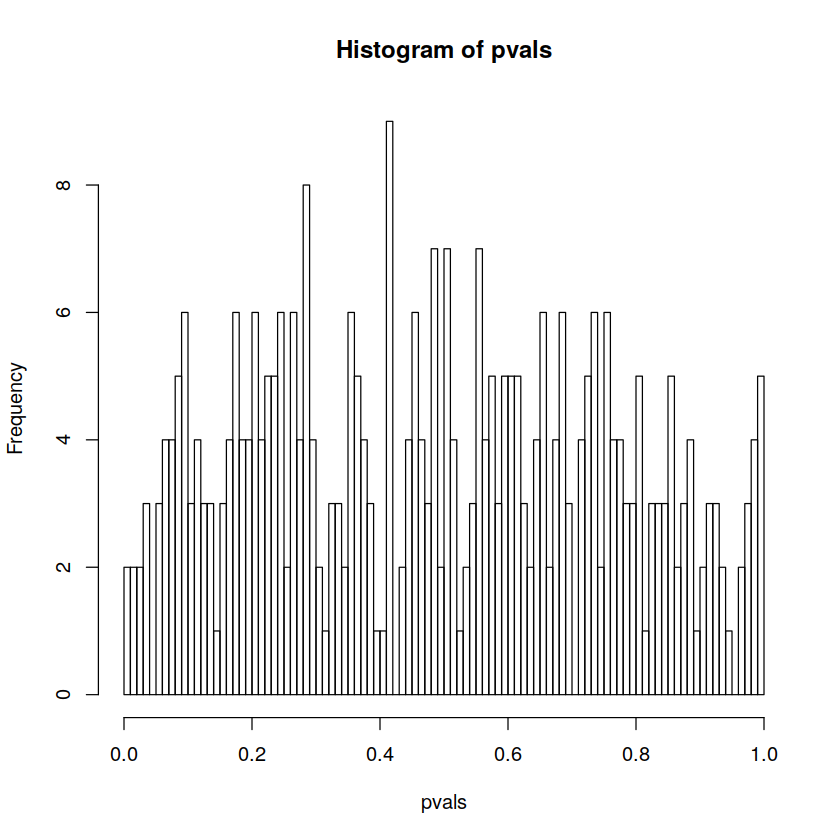

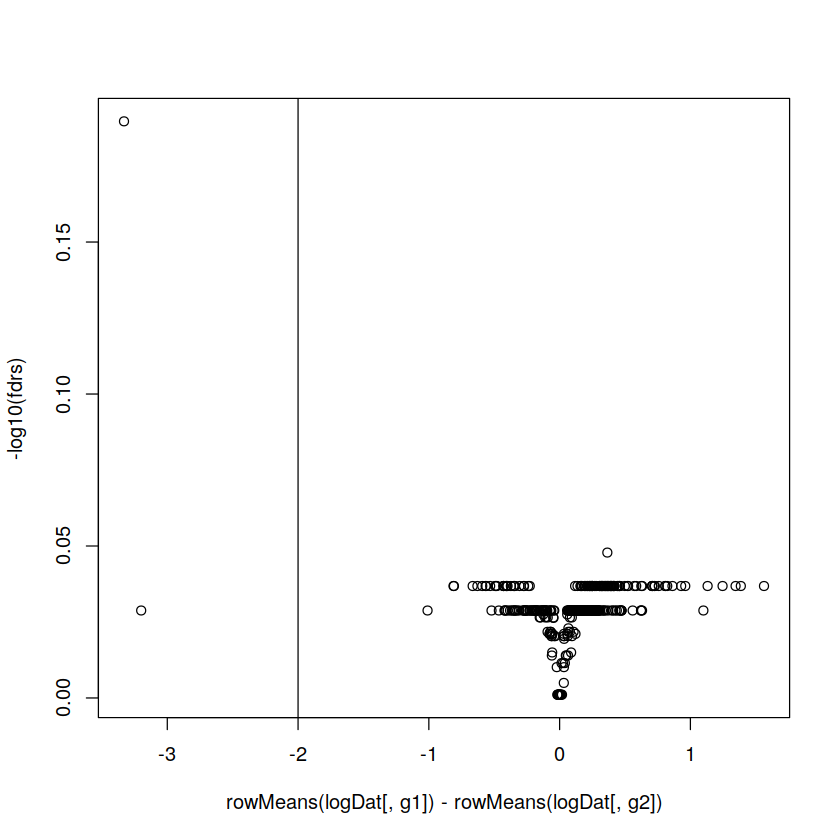

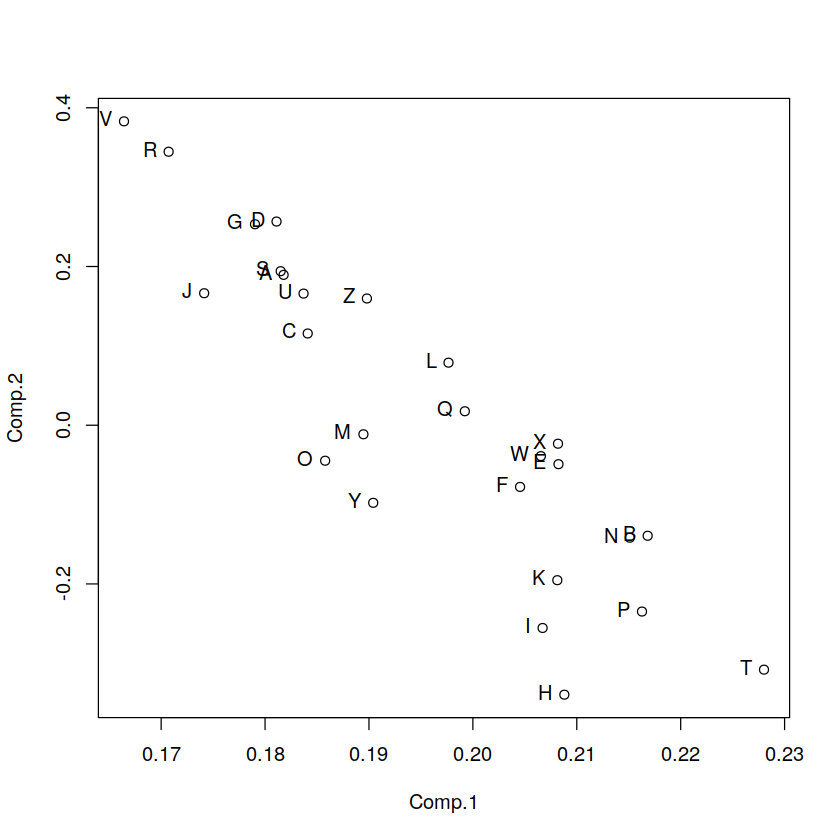

In [16]:
data(geneData)
geneData[geneData<=0] <- NA
logDat <- log2(geneData)
logDat <- logDat[complete.cases(logDat),]
pvals <- vector(,nrow(logDat))
for(i in 1:nrow(logDat)) {
  pvals[i] <- t.test(logDat[i, c("B", "I", "K", "N", "P", "T")], logDat[i, c("C", "G", "J", "O", "R", "U", "V")])$p.value
}

pvals2 <- apply(logDat, 1, function(x) t.test(x[c("B", "I", "K", "N", "P", "T")] , x[c("C", "G", "J", "O", "R", "U", "V")])$p.value)

hist(pvals, 100)
fdrs <- p.adjust(pvals, method = "BH")

plot(rowMeans(logDat[, c("B", "I", "K", "N", "P", "T")]) - 
     rowMeans(logDat[, c("C", "G", "J", "O", "R", "U", "V")]), 
    -log10(fdrs))                
abline(h=1)
abline(v=c(-2,2))

                
samples <- sample(LETTERS, 12)
g1 <- samples[1:6]
g2 <- samples[7:12]
pvals <- vector(,nrow(logDat))
for(i in 1:nrow(logDat)) {
  pvals[i] <- t.test(logDat[i, g1], logDat[i, g2])$p.value
}

pvals2 <- apply(logDat, 1, function(x) t.test(x[g1] , x[g2])$p.value)

hist(pvals, 100)
fdrs <- p.adjust(pvals, method = "BH")

plot(rowMeans(logDat[, g1]) - 
     rowMeans(logDat[, g2]), 
    -log10(fdrs))                
abline(h=1)
abline(v=c(-2,2))
                
                
pca.out <- princomp(logDat)
plot(pca.out$loadings)
text(pca.out$loadings, colnames(logDat), pos=2)
                
                
                
                
# ...
                
                

##### Question I:  <u>How many differentially regulated genes do you find in a) and in b) (p-value below 0.01)?</u>

_Answer_

##### Question II:  <u>Why does a volcano plot look like a volcano?</u>

_Answer_

##### Question III:  <u>What does the PCA tell you about part a) of this exercise?</u>

_Answer_



### Exercise 3

In bottom-up LC-MS experiments, the output are peptides which can be shared between different proteins. This is why the results most of the time report protein groups instead of single proteins. Here, you will apply different operations on the reported protein groups. 

Read the file _Example.csv_ and extract the column with the protein accession numbers. 

a) Pick out one of the values and apply ```strsplit``` to separate database name (e.g. TREMBL, SWISS-PROT) from accession id.

b) Take a value with multiple protein accessions and extract only the accession ids.

c) Operate ```strsplit``` on the entire column and try to extract the accession ids.

d) Count the number of proteins per protein group and plot their distribution as histogram.


[1]                                                                
[3] IPI00949815.1                   SWISS-PROT:P13437;IPI00948721.1
[5] IPI00948721.1                   IPI00948721.1                  
309 Levels:  ENSEMBL:ENSRNOP00000000474 ... TREMBL:Q9WUN0

[1] "P13437;IPI00948721.1"

[1] "P13437"        "IPI00948721.1"


  0   1   2   4   5   7   8 
495 590  97   4   1  22   3 

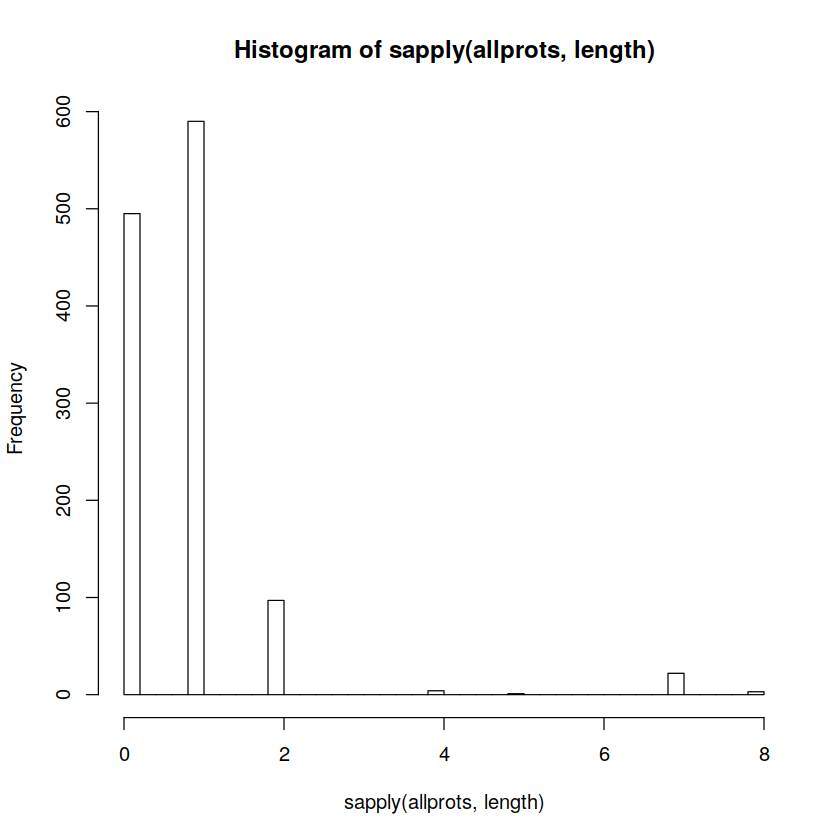

In [53]:
A <- read.csv("ExampleFile.csv")
protaccs <- A$Protein.Accessions
protaccs[60:65]
# a)
example_str <- strsplit(as.character(protaccs[63]),":",fixed = T)
example_str[[1]][2]
# b)
unlist(strsplit(strsplit(as.character(protaccs[63]),":",fixed = T)[[1]][2],";",fixed=T))
# c) Still some SWISS-PROT in the array though
# c) Still some SWISS-PROT in the array though
allprots <- list()
for (i in 1:length(protaccs)) {
  str1 <- strsplit(as.character(protaccs[i]),":",fixed = T)
#   print(str1[[1]])
  if (length(str1[[1]])>1)
    allprots[[i]] <- unlist(strsplit(str1[[1]][2],";",fixed=T))
}
         
# d) This one is on you
hist(sapply(allprots, length), 50)
table(sapply(allprots, length))


##### Question I:  <u>What is the difference between TREMBL and SWISS-PROT annotations?</u>

_Answer_

##### Question II:  <u>What is the advantage of measuring multiple peptides of a protein?</u>

_Answer_

##### Question 3:  <u>How many proteins contains the largest protein group?</u>

_Answer_



### Exercise 4

We will test different normalization methods on micro-array data from _Drosophila melanogaster_ development (https://www.nature.com/articles/nature09634). 

a) Make a boxplot and compare the different developmental stages. 

Make a scatter plot and change sample numbers to see how they compare quantitatively.

Look at the MA plot and understand what it shows

b) Carry out median normalization and look at the plots of the normalized data

c) Carry out quantile normalization ```normalize.quantiles(microarray)``` and look at the plots again



In [ ]:
microarray <- me_Kalinka[,2:ncol(me_Kalinka)]

#boxplot(microarray)

sample1 <- 1
sample2 <- 7

plot(rowMeans(microarray,na.rm=T),microarray[,sample2]-microarray[,sample1],cex=0.5,pch=15, col="#00000033", 
     xlab=paste("Sample",sample1), ylab=paste("Sample",sample2))
abline(h=0)

# add different normalizations here


# plot again

##### Question I:  <u>Can you spot the difference between the developmental states from the boxplot?</u>

_Answer_

##### Question II:  <u>What complicates normalization of such a data set with large differences?</u>

_Answer_


##### Question III:  <u>What are the sometimes rather drastic changes in the data when using quantile normalization?</u>

_Answer_


##### Question IV:  <u>Which normalization would you recommend?</u>

_Answer_



### Exercise 5

In this exercise, you will apply statistical tests to proteomics data.

Carry out t-tests between the two cancer subtypes of the ```CanceriTRAQ``` data (from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0137048). Plot the p-values (corrected for multiple testing) in a volcano plot and compare the results to the ones in the _IsoProt_ paper (https://pubs.acs.org/doi/10.1021/acs.jproteome.8b00968)

Compare the results for the two types of correction for multiple testing "Benjamini-Hochberg" and the ```qvalue``` library ("Storey" method). You can make a scatter plot of the FDRs (corrected p-values) on log-scale and also compare by making two volcano plots.


In [ ]:
CanceriTRAQRed <- CanceriTRAQ[rowSums(is.na(CanceriTRAQ))<3,]
# Add your code here:


##### Question I:  <u>What does the first line of code do?</u>

_Answer_

##### Question II:  <u>How many p-values <0.05 and 0.1 do you get? How many after correction for multiple testing?</u>

_Answer_

##### Question III:  <u>What would be needed to increase the number of significantly changing proteins?</u>

_Answer_

##### Question IV:  <u>How many p-values below 0.05 would a randomized data set of the same size give without correction for multiple testing?</u>

_Answer_

##### Question V:  <u>Name the difference you observe when comparing the two methods ("Benjamini-Hochberg" and "Storey")</u>

_Answer_



### Exercise 6

The ```limma``` package provides better estimates of the p-values by adjusting the observed variances of the features to the generally observed trends in the data. We will further use different tools for biological interpretation.

Carry out limma testing on the cancer data and compare the results to the ones from the t-tests.

Take the 50 most regulated proteins and upload them to the following two web services for biological interpretation:

- DAVID: http://david.ncifcrf.gov
- GOrilla http://cbl-gorilla.cs.technion.ac.il/



In [ ]:
## limma
# Set replicate numbers
Reps <- c(1,1,1,1,2,2,2,2)
Data <- CanceriTRAQ
NumCond <- max(Reps)
  design <- model.matrix(~0+factor(Reps-1))
  colnames(design)<-paste("i",c(1:NumCond),sep="")
  contrasts<-NULL
  First <- 1
  for (i in (1:NumCond)[-First]) contrasts<-append(contrasts,paste(colnames(design)[i],"-",colnames(design)[First],sep=""))
  contrast.matrix<-makeContrasts(contrasts=contrasts,levels=design)
  print(dim(Data))
  lm.fitted <- lmFit(Data,design)
  
  lm.contr <- contrasts.fit(lm.fitted,contrast.matrix)
  lm.bayes<-eBayes(lm.contr)
  #topTable(lm.bayes)
# These are the (uncorrected) p-values from the moderated t-test from the limma package:
  plvalues <- lm.bayes$p.value
head(sort(p.adjust(plvalues, method="BH")))



##### Question I:  <u>How many regulated proteins do you find this time (FDR < 0.05)?</u>

_Answer_

##### Question II:  <u>Which are the most enriched Gene ontology terms (GO terms, BP) in both web sites?</u>

_Answer_

##### Question III:  <u>Which pathways are likely to distinguish the two cancer subtypes?</u>

_Answer_

